In [1]:
using LinearAlgebra
# using StatsBase
using Random
import PyPlot as plt
# using NPZ
# using ProgressMeter
# using Optim 
# using LaTeXStrings
# using SpecialFunctions
using DifferentialEquations
# using Clustering 
# using StatsPlots
include("recallLib.jl")

autobasinFluct (generic function with 1 method)

In [2]:
# Global variables 
const sx = 1
const sy = 2 
const sz = 3
const rx = 4
const ry = 5

function makeTable(n)

    tb = Int.(zeros(5,n))

    cnt = 1

    for i=1:n 
        tb[sx,i] = cnt 
        cnt += 1

        tb[sy,i] = cnt 
        cnt += 1

        tb[sz,i] = cnt 
        cnt += 1

        tb[rx,i] = cnt 
        cnt += 1

        tb[ry,i] = cnt 
        cnt += 1

    end

    return tb
end
# tb = makeTable(5)
# display(tb)

function Green(xi,xj,yi,yj,α,γ)

    t = exp(-α)
    a = 1+γ
    b = 1 - γ^2*t^2

    return a^2/(4*b) * exp( -a/(2*b) * ((1+γ*t^2)*(xi^2 + yi^2 + xj^2 + yj^2) - 2*a*t*(xi*xj+yi*yj)) )
end

function Gη(xi,xj,yi,yj,α,γ)

    val = Green(xi,xj,yi,yj,α,γ)

    val += 2*real(Green(xi,xj,yi,yj,α-2π*1*im/7,γ))
    val += 2*real(Green(xi,xj,yi,yj,α-2π*2*im/7,γ))
    val += 2*real(Green(xi,xj,yi,yj,α-2π*3*im/7,γ))

    return val/7
end

function uniquecount(data)
    unique_array = unique(data)
    counts = Dict(unique_array .=> 0)
    for (i, c) in enumerate(data)
       counts[c] += 1     
    end
    vals = collect(keys(counts))
    cnts = collect(values(counts))
    idx = sortperm(cnts,rev=true)
    return vals[idx],cnts[idx]
 end

 function flipSpins!(s,nFlips)

    n = length(s)
    idxs = sample(1:n,nFlips,replace=false)

    for i=1:nFlips 
        s[idxs[i]] *= -1
    end

 end

flipSpins! (generic function with 1 method)

In [3]:
function deriv!(du,u,p,t)

    n  = Int(p[1])
    ωz = p[2]
    S = p[3] # Size of the spins
    α = p[4] # Resolution parameter for the cavity
    γ = p[5] # The term that depends on the width of the atom distribution. 
    dmdSpins = p[6] # Spin state on the DMD, this is an n-dimensional array  
    gfunc = p[7] # Trans pump Rabi frequency, function of time. 
    λ = p[8] # Max eigenvalue of initial J matrix
    tb = p[9] # Lookup table for variables
    dmdx = p[10] # X positions of dmd spots in waists, array
    dmdy = p[11] # Y positions of dmd spots in waists, array
    dmdFunc = p[12] # Prefactor in front of DMD strength, function of time.
    trapX = p[13] # X locations of XODTS, 1d array of length n
    trapY = p[14] # Y locations of XODTS, 1d array of length n
    trapSize = p[15]
    η = p[16] # Spin-position coupling strength
    Jholder = p[17]
    doMovement = p[18]

    # Compute constants
    g = gfunc(t)
    gcoef = g*ωz/(S*λ)
    f = dmdFunc(t)
    fcoef = f*ωz/λ

    # Get views of the variables 
    spins = @view u[tb[sx,:]]
    xs    = @view u[tb[rx,:]]
    ys    = @view u[tb[ry,:]]

    for i=1:n

        # Compute J matrix
        for j=i:n 
            Jholder[i,j] = Gη(xs[i], xs[j], ys[i], ys[j], α, γ)
            Jholder[j,i] = Jholder[i,j]
        end

        # Spin mean-field dynamics
        du[tb[sx,i]] = -ωz*u[tb[sy,i]]
        du[tb[sy,i]] =  ωz*u[tb[sx,i]]
        du[tb[sz,i]] = 0
        fsum = 0
        rotRate = 0
        for j=1:n 

            # Ising terms
            rotRate += Jholder[i,j] * u[tb[sx,j]]

            # Longitudinal field term
            fsum += dmdSpins[j] * Gη(xs[i], dmdx[j], ys[i], dmdy[j], α, γ) 
        end
        rotRate *= gcoef
        fsum *= fcoef

        # Ising and longitudinal spin terms
        du[tb[sy,i]] +=  (rotRate + fsum)*u[tb[sz,i]]
        du[tb[sz,i]] += -(rotRate + fsum)*u[tb[sy,i]]

        if doMovement
            # # External trap
            # du[tb[rx,i]] = -(xs[i] - trapX[i])/trapSize^2 
            # du[tb[ry,i]] = -(ys[i] - trapY[i])/trapSize^2

            # # Ising spin position coupling
            # du[tb[rx,i]] += gcoef * dIsingdxi(xs,ys,spins,i,α,γ)
            # du[tb[ry,i]] += gcoef * dIsingdxi(ys,xs,spins,i,α,γ)

            # # # Longitudinal field motional dependence
            # du[tb[rx,i]] += fcoef * dLongdxi(xs,ys,spins,dmdx,dmdy,dmdSpins,i,α,γ)
            # du[tb[ry,i]] += fcoef * dLongdxi(ys,xs,spins,dmdy,dmdx,dmdSpins,i,α,γ)

            # du[tb[rx,i]] *= η
            # du[tb[ry,i]] *= η
        else 
            du[tb[rx,i]] = 0
            du[tb[ry,i]] = 0
        end
        
    end
end

# Do it 
function main(seed,xvals,yvals,dmdx,dmdy,dmdSpins,α,γ,trapSize,η,dmdAmp,transAmp,doMovement,tmax;quiet=false)

    S = 1
    n = length(xvals)

    # Set the seed
    Random.seed!(seed)

    # ODE Parameters 
    nsteps = 200
    solver = TsitPap8() #CFRLDDRK64()  ## #TSLDDRK74() # TsitPap8() #CFRLDDRK64()
    abstol = 1e-7 #1e-10 Defaults is 1e-6
    reltol = 1e-7 #1e-10 Default is 1e-3
    maxiters = 1e6

    # Make the lookup table
    tb = makeTable(n)
    totalVars = maximum(tb)

    # Initial condition
    u0 = zeros(totalVars)
    for i=1:n 
        u0[tb[sx,i]] = 0
        u0[tb[sy,i]] = 0
        u0[tb[sz,i]] = -S
        u0[tb[rx,i]] = xvals[i] 
        u0[tb[ry,i]] = yvals[i]
    end

    # Set the other parameters
    ωz = 2π*8e-3
    # dmdx  = copy(xvals)                  # X positions of dmd spots in waists, array
    # dmdy  = copy(yvals)                  # Y positions of dmd spots in waists, array
    trapX = copy(xvals)                 # X locations of XODTS, 1d array of length n
    trapY = copy(yvals)                 # Y locations of XODTS, 1d array of length n
    longNoise = 2π*1e-9

    # Construct the nominal J matrix 
    J = zeros(n,n)
    for i=1:n
        for j=i:n 
            J[i,j] = Gη(xvals[i],xvals[j],yvals[i],yvals[j],α,γ)
            J[j,i] = J[i,j]
        end
    end

    # Find maximum eigenvalue
    λ = maximum( eigen(J).values )

    # Make the transverse and longitudinal pump Functions
    # Ωfunc(t) = Ωc*sqrt(4*t/tmax) 
    # offset = 0.8
    # offset1 = exp(log(sqrt(offset)))
    # final = exp( log(sqrt(4)) )
    # Ωfunc(t) = sqrt(4)*Ωc*( exp( (t/tmax)*log(sqrt(4)) + (1-t/tmax)*log(sqrt(offset)) ) - offset1 )/(final-offset1) 
    function gfunc(t)
        if t<tmax/5
            return 0
        elseif t<tmax*3/4
            t -= tmax/5
            return transAmp * t/(tmax*3/4-tmax/5) 
        else
            return transAmp
        end
    end

    # DMD power and long field strength
    # function dmdPow(t)
    #     turnon = 0.05
    #     if t<tmax/2
    #         return min(t/tmax,turnon)/turnon /(Ωfunc(tmax/2)^2)
    #     elseif t<tmax*3/4
    #         return 1/(Ωfunc(t)^2) 
    #     else
    #         return max(0, 1 - (t/tmax-3/4)*4 *2 )/(Ωfunc(t)^2) 
    #     end
    # end
    # dmdFunc(t) = 2π*dmdAmp*sqrt(dmdPow(t))*Ωfunc(t)

    # Simpler version
    # dmdFunc(t) = 2π*dmdAmp*(1-cos(2π*min(1,t/tmax * 2)))/2

    function dmdFunc(t)
        if t<tmax/5
            return dmdAmp*(1-cos(2π*t/tmax * 5/2))/2
        else
            t -= tmax/5
            return dmdAmp*(1+cos(2π*min(0.5,t/(tmax*3/4 -tmax/5) /2 )))/2
        end
    end

    # Make parameter list 
    p = []
    for i=1:18
        push!(p,nothing)
    end
    p[1]  = n 
    p[2]  = ωz 
    p[3]  = S
    p[4]  = α
    p[5]  = γ
    p[6]  = dmdSpins
    p[7]  = gfunc
    p[8]  = λ 
    p[9]  = tb
    p[10] = dmdx
    p[11] = dmdy
    p[12] = dmdFunc
    p[13] = copy(xvals)
    p[14] = copy(yvals)
    p[15] = trapSize
    p[16] = η
    p[17] = zeros(n,n)
    p[18] = doMovement
    p = tuple(p...) # Tuples supposedly have better performance
    # display(p) 
    
    # Make ODE function object
    fun = ODEFunction(deriv!)

    # Initialize ODE problem object and integrator 
    tspan = (0,tmax)
    dt = tmax/nsteps
    stochasticInc = sqrt(dt*longNoise)
    prob = ODEProblem(fun,u0,tspan,p)
    integrator = init(prob,solver,dt=dt,save_on=false,abstol=abstol,reltol=reltol,save_everystep=false,maxiters=maxiters)

    # Observables 
    tvals  = zeros(nsteps)
    sxExp  = zeros(nsteps,n)
    syExp  = zeros(nsteps,n)
    szExp  = zeros(nsteps,n)
    xExp   = zeros(nsteps,n)
    yExp   = zeros(nsteps,n)
    IsingE = zeros(nsteps)
    LongE  = zeros(nsteps)

    # Do it 
    if quiet==false
        println("Integrating... ")
    end
    start=time()
    for k=1:nsteps

        # Stochastic step
        for i=1:n 
            dW = randn()
            yval = integrator.u[tb[sy,i]]
            zval = integrator.u[tb[sz,i]]
            integrator.u[tb[sy,i]] += -stochasticInc*dW*zval
            integrator.u[tb[sz,i]] +=  stochasticInc*dW*yval

            # Renormalize 
            norm = sqrt( integrator.u[tb[sx,i]]^2 + integrator.u[tb[sy,i]]^2 + integrator.u[tb[sz,i]]^2 )
            integrator.u[tb[sx,i]] *= S/norm
            integrator.u[tb[sy,i]] *= S/norm
            integrator.u[tb[sz,i]] *= S/norm
        end

        # Deterministic step
        step!(integrator,dt,true)

        # Compute constants
        g = gfunc(integrator.t)
        gcoef = g*ωz/(S*λ)
        f = dmdFunc(integrator.t)
        fcoef = f*ωz/λ

        # Measure expectation values of observables.
        tvals[k] = integrator.t
        E = 0
        Elong = 0
        Etrap = 0
        for i=1:n
            sxExp[k,i] = integrator.u[tb[sx,i]]
            syExp[k,i] = integrator.u[tb[sy,i]]
            szExp[k,i] = integrator.u[tb[sz,i]]
            xExp[k,i]  = integrator.u[tb[rx,i]]
            yExp[k,i]  = integrator.u[tb[ry,i]]

            for j=1:n 
                Jij = Gη(integrator.u[tb[rx,i]], integrator.u[tb[rx,j]], integrator.u[tb[ry,i]], integrator.u[tb[ry,j]], α, γ)
                E += - gcoef * Jij * integrator.u[tb[sx,i]] * integrator.u[tb[sx,j]]

                Gij = Gη(integrator.u[tb[rx,i]], dmdx[j], integrator.u[tb[ry,i]], dmdy[j], α, γ)
                Elong += - fcoef * Gij * integrator.u[tb[sx,i]] * dmdSpins[j]
            end
        end
        IsingE[k] = E
        LongE[k] = Elong
        
    end
    if quiet==false
        print(round((time()-start)/60,digits=1));println(" (m)")
    end

    return tvals,sxExp,syExp,szExp,xExp,yExp,IsingE,LongE,S,gfunc,dmdFunc
end



main (generic function with 1 method)

In [4]:
# Set random seed
seed = rand(1:100000)
println("Seed:"*string(seed))

# Parameters
α = 0.001                           # Resolution parameter for the cavity
σ = 0.15                            # Units of waists
γ = (1-2*σ^2)/(1+2*σ^2)             # The term that depends on the width of the atom distribution. 
trapSize = 3.3
η = 0                             # The overall relaxation rate for the motional dynamics
transAmp = 4
dmdAmp = 0  #0.0001
doMovement = false 
tmax = 5e3      # microseconds

# Choose positions
nx = 4
ny = 4
x0 = range(-3,3,length=nx) .+ 0.1
y0 = range(-3,3,length=ny) .+ 0.03
n=nx*ny

# # Rescale the trapSize (trap strength) by the number of clumps
# trapSize /= n

# Make noisy initial positions 
x0f = x0 #.+ randn(nx)*0.0/34.8
y0f = y0 #.+ randn(ny)*0.0/34.8

# Compute rectilinear coordinates
xvals = zeros(n)
yvals = zeros(n)
xvalsf = zeros(n)
yvalsf = zeros(n)
cnt = 1
for i=1:nx
    for j=1:ny
        xvals[cnt] = x0[i]
        yvals[cnt] = y0[j] 
        xvalsf[cnt] = x0f[i]
        yvalsf[cnt] = y0f[j] 

        cnt += 1
    end
end
# display(xvals)
# display(yvals)

# Compute nominal J matrix
# Set diagonal to zero though
J = zeros(n,n)
for i=1:n
    for j=i+1:n 
        J[i,j] = Gη(xvals[i],xvals[j],yvals[i],yvals[j],α,γ)
        J[j,i] = J[i,j]
    end
end

# Do it
tvals,sxExp,syExp,szExp,xExp,yExp,IsingE,LongE,S,gfunc,dmdFunc = main(seed,xvalsf,yvalsf,xvalsf,yvalsf,zeros(n),α,γ,trapSize,η,dmdAmp,transAmp,doMovement,tmax);
println("")

########### Analysis ###############
finalState = Int.(sign.(sxExp[end,:]));
display(Int.((1 .+finalState')./2))


Seed:67115
Integrating... 
0.0 (m)



1×16 Matrix{Int64}:
 0  1  0  0  1  0  0  0  0  0  1  0  1  0  0  1

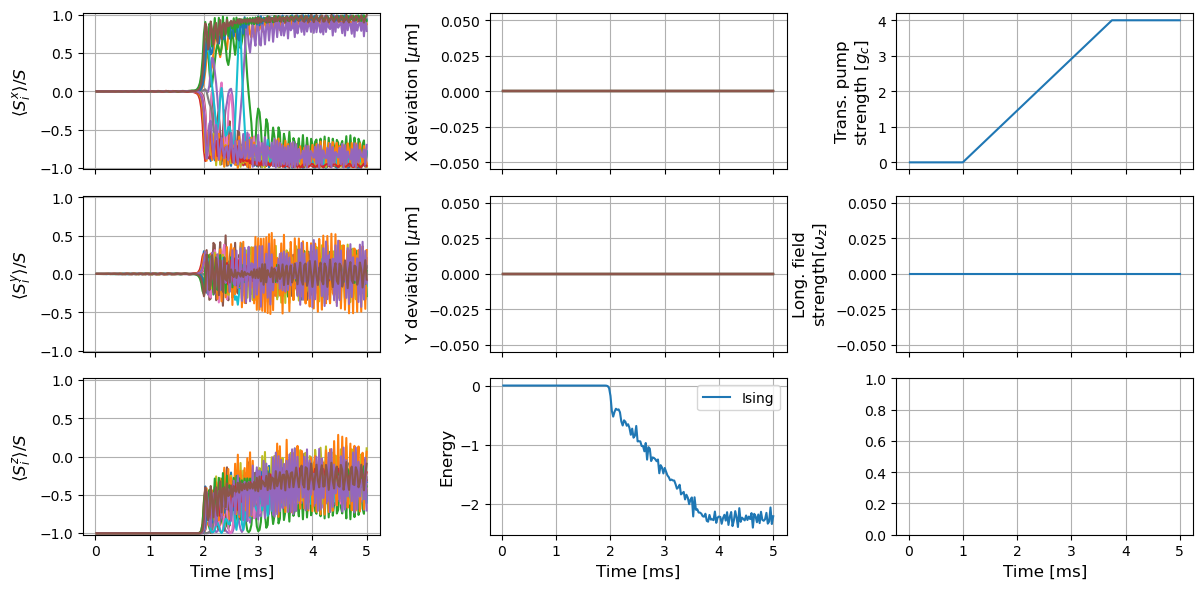

Final energy=-2.2134759159319457
Minimum longitudinal energy=0.0


In [5]:
# Plots ##############
fig,ax = plt.subplots(3,3,sharex=true,figsize=(12,6))
ax[1].plot(tvals/1e3,sxExp./S)
ax[2].plot(tvals/1e3,syExp./S)
ax[3].plot(tvals/1e3,szExp./S)
for i=1:9
    if i<4
        ax[i].set_ylim(-1.02,1.02)
        # ax[i].set_ylim(-0.05,0.05)
    end
    ax[i].grid()
end
ax[3].set_xlabel("Time [ms]",fontsize=12)
ax[6].set_xlabel("Time [ms]",fontsize=12)
ax[9].set_xlabel("Time [ms]",fontsize=12)
ax[1].set_ylabel(L"$\langle S_i^x \rangle/S$",fontsize=12)
ax[2].set_ylabel(L"$\langle S_i^y \rangle/S$",fontsize=12)
ax[3].set_ylabel(L"$\langle S_i^z \rangle/S$",fontsize=12)
ax[4].set_ylabel("X deviation "*L"$[\mu\mathrm{m}]$",fontsize=12)
ax[5].set_ylabel("Y deviation "*L"$[\mu\mathrm{m}]$",fontsize=12)

for i=1:n
    ax[4].plot(tvals/1e3,(xExp[:,i] .- xvals[i]).*34.8)
    ax[5].plot(tvals/1e3,(yExp[:,i] .- yvals[i]).*34.8)
end

ax[6].plot(tvals/1e3,IsingE,color="tab:blue",label="Ising")
# ax[6].plot(tvals/1e3,LongE,color="tab:orange",label="Long.")
ax[6].set_ylabel("Energy",fontsize=12)
ax[6].legend()

ax[7].plot(tvals/1e3,gfunc.(tvals))
ax[7].set_ylabel(L"$\Omega^2/\Omega_c^2$",fontsize=12)
ax[7].set_ylabel("Trans. pump\nstrength "*L"$[g_c]$",fontsize=12)

ax[8].plot(tvals/1e3,dmdFunc.(tvals))
ax[8].set_ylabel("Long. field\nstrength"*L"$[\omega_z]$",fontsize=12)

plt.tight_layout()

plt.display_figs()

println("Final energy="*string(IsingE[end]))
println("Minimum longitudinal energy="*string(minimum(LongE)))